In [1]:
import os
import matplotlib.pyplot as plt

from sda.mcs import *
from sda.score import *
from sda.utils import *

from experiments.kolmogorov.utils import *
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
class TrajectoryDataset(Dataset):
    def __init__(
        self,
        file: Path,
        window: int = None,
        flatten: bool = False,
        normalize: float = True,
        mean: float = None,
        std: float = None
    ):
        super().__init__()

        with h5py.File(file, mode='r') as f:
            self.data = f['x'][:]

        self.window = window
        self.flatten = flatten
        self.normalize = normalize
        self.mean = self.data.mean() if mean is None else mean
        self.std = self.data.std() if mean is None else std

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, i: int) -> Tuple[Tensor, Dict]:
        x = torch.from_numpy(self.data[i])

        if self.normalize:
            x = (x - self.mean) / self.std

        if self.window is not None:
            i = torch.randint(0, len(x) - self.window + 1, size=())
            x = torch.narrow(x, dim=0, start=i, length=self.window)

        if self.flatten:
            return x.flatten(0, 1), {}
        else:
            return x, {}

In [3]:
window = 5

CONFIG = {
    # Architecture
    'window': window,
    'embedding': 64,
    'hidden_channels': (96, 192, 384),
    'hidden_blocks': (3, 3, 3),
    'kernel_size': 3,
    'activation': 'SiLU',
    # Training
    'epochs': 1000,
    'batch_size': 32,
    'optimizer': 'AdamW',
    'learning_rate': 2e-4,
    'weight_decay': 1e-3,
    'scheduler': 'cosine',
}

In [4]:
out_root = Path("./runs_sqg")      # output root (you can change)
out_root.mkdir(parents=True, exist_ok=True)

exp_name = f"mcscore_vpsde_sqg_window_{window}"
run_dir  = out_root / exp_name
ckpt_dir = run_dir / "checkpoints"
fig_dir  = run_dir / "figures"
hist_dir = run_dir / "history"

score = make_score(**CONFIG)
sde = VPSDE(score.kernel, shape=(CONFIG['window']*2, 64, 64))
sde = sde.to(device)

files = sorted(ckpt_dir.glob("epoch_*.pt"))
path = files[-1]
payload = torch.load(path, map_location=device)
score.load_state_dict(payload["score_state"])
sde.load_state_dict(payload["sde_state"])

<All keys matched successfully>

In [5]:
nx = 64
ny = 64

ARGS = {
    # Guidance
    'obs_type': 'random', # 'grid' or 'random'
    'obs_stride': 4, # applicable for obs_type=grid
    'obs_pct': 0.05, # observation percentage (applicable for obs_type=random)
    'obs_fn': 'linear',
    'n_ens': 20,
    'assim_window': 100,
    'guidance_method': 'vanilla'
}

if ARGS['obs_type'] == 'grid':
    stride = int(ARGS.get('obs_stride', 4))
    grid2d = torch.zeros(nx, ny, device=device)
    grid2d[::stride, ::stride] = 1.0
    obs_mask = grid2d.flatten()
    obs_mask = obs_mask.unsqueeze(0).view(1, nx, ny)
elif ARGS['obs_type'] == 'random':
    rsobs = np.random.RandomState(42) # fixed seed for observations
    nobs = int(nx*ny*ARGS['obs_pct'])
    indxob = np.sort(rsobs.choice(nx*ny, nobs, replace=False))
    
    sparse_index = torch.zeros(nx*ny, dtype=torch.bool, device=device)
    sparse_index[indxob] = True
    
    obs_mask = torch.ones(1, nx*ny, device=device)
    obs_mask[:, ~sparse_index] = 0
    obs_mask = obs_mask.view((nx, ny))
else:
    raise NotImplementedError

if ARGS['obs_fn'] == 'linear':
    obs_fn = lambda x: x
elif ARGS['obs_fn'] == 'arctan':
    obs_fn = lambda x: torch.atan(x)
else:
    raise NotImplementedError
    

In [6]:
# Working cell (untouched)

def A(x):
    return obs_fn(x) * obs_mask

data_dir = "/central/scratch/sotakao/sqg_train_data/3hrly"
train_fname = "sqg_pv_train.h5"
valid_fname = "sqg_pv_valid.h5"

# trainset = TrajectoryDataset(os.path.join(data_dir, train_fname), normalize=True, window=ARGS['assim_window'], flatten=True)

train_mean = 0
train_std = 2672.232
validset = TrajectoryDataset(os.path.join(data_dir, valid_fname), normalize=True, window=ARGS['assim_window'], flatten=True,
                             mean=train_mean, std=train_std)

# trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=32, shuffle=True, num_workers=1, persistent_workers=True)


In [7]:
x_star = validset[0][0].to(device)
y_star = torch.normal(A(x_star), 0.1)
y_star = y_star.unflatten(0, (-1, 2))

if ARGS['guidance_method'].lower() == 'vanilla':
    guided_sde = VPSDE(
                GaussianScore(
                    y_star,
                    A=A,
                    std=0.1,
                    sde=VPSDE(score, shape=())
                ),
                shape=y_star.shape,
            ).cuda()
elif ARGS['guidance_method'].lower() == 'dps':
    guided_sde = VPSDE(
                DPSGaussianScore(
                    y_star,
                    A=A,
                    zeta=1.0,
                    sde=VPSDE(score, shape=()),
                ),
                shape=y_star.shape,
            ).cuda()
else:
    raise NotImplementedError

posterior_sample = guided_sde.sample((1,),
                                     steps=100,
                                     corrections=1,
                                     tau=0.5).cpu()

100%|█████████████████████████████████████████████████| 100/100 [03:14<00:00,  1.95s/it]


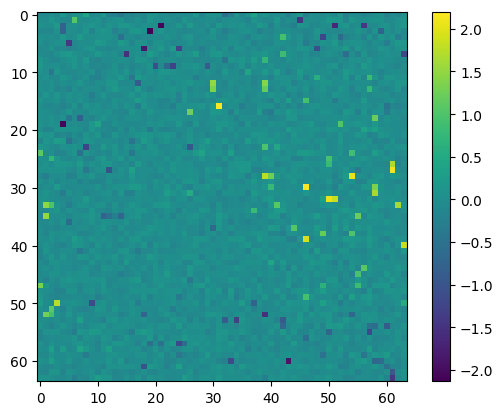

In [8]:
plt.imshow(y_star[0,0].cpu().numpy())
plt.colorbar()

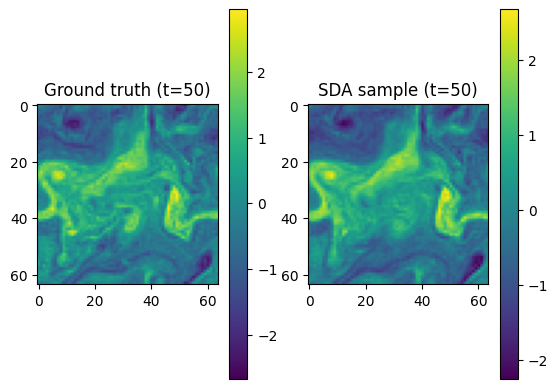

In [9]:
t = 50
ens = 0
x_star_ = x_star.unflatten(0, (-1, 2)).cpu()
fig, axs = plt.subplots(1, 2)
im0 = axs[0].imshow(x_star_[t,0])
axs[0].set_title(f"Ground truth (t={t})")
plt.colorbar(im0)
im1 = axs[1].imshow(posterior_sample[0,t,0])
axs[1].set_title(f"SDA sample (t={t})")
plt.colorbar(im1)

CalledProcessError: Command '['convert', '-size', '640x480', '-depth', '8', '-delay', '10.0', '-loop', '0', 'rgba:-', '-layers', 'OptimizePlus', 'sda_posterior_linear_type_random_method_DPS.gif']' returned non-zero exit status 2.

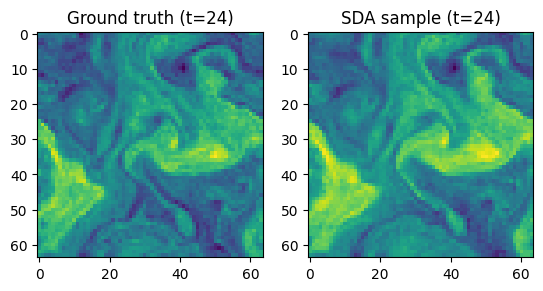

In [10]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

ens = 0
ARGS['guidance_method'] = 'DPS'

# Assuming x_star_ and posterior_sample are already defined
x_star_ = x_star.unflatten(0, (-1, 2)).cpu()

fig, axs = plt.subplots(1, 2)

def update(t):
    axs[0].clear()
    axs[1].clear()
    
    axs[0].imshow(x_star_[t, 0])
    axs[0].set_title(f"Ground truth (t={t})")
    
    axs[1].imshow(posterior_sample[0, t, 0])
    axs[1].set_title(f"SDA sample (t={t})")

ani = FuncAnimation(fig, update, frames=range(100), interval=100)  # 500ms per frame

# Save
ani.save(f"sda_posterior_{ARGS['obs_fn']}_type_{ARGS['obs_type']}_method_{ARGS['guidance_method']}.gif", writer='imagemagick')
plt.show()

# Scaled version

In [11]:
from netCDF4 import Dataset as NetCDFDataset

# Load pv_truth from NetCDF (test file)
test_file = "/central/scratch/sotakao/sqg_train_data/3hrly/sqg_N64_3hrly_100.nc"
nc_truth = NetCDFDataset(test_file, 'r')
pv_truth_nc = nc_truth.variables['pv']  # expected shape: (T, 2, ny, nx)
T, Z, ny, nx = pv_truth_nc.shape
pv_truth = torch.tensor(np.array(pv_truth_nc[:T, ...]), dtype=torch.float32, device=device)  # (T, 2, ny, nx)

scalefact = nc_truth.f*nc_truth.theta0/nc_truth.g # 0.003061224412462883
pv_std = train_std

nc_truth.close()

In [12]:
obs_sigma = 0.5
noise = torch.randn_like(pv_truth) * obs_sigma
y = scalefact*pv_truth*obs_mask.unsqueeze(0) + noise*obs_mask.unsqueeze(0)
# y = torch.normal(scalefact*pv_truth*obs_mask.unsqueeze(0), obs_sigma)

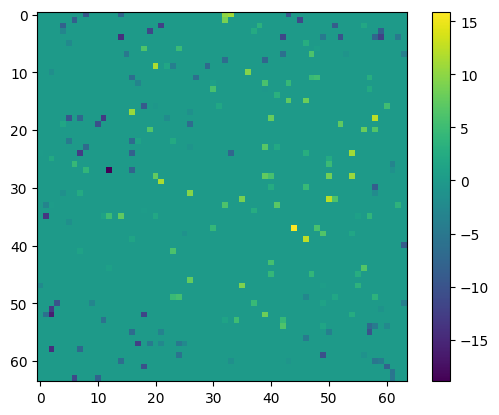

In [13]:
plt.imshow(y[0,0].cpu().numpy())
plt.colorbar()

In [25]:
def A(x):
    return obs_fn(x) * obs_mask

scale = scalefact*pv_std
score_scaled = lambda x, t, c: score(x/scale, t, c)

guided_sde = ScaledVPSDE(
                DPSGaussianScore(
                    y,
                    A=A,
                    std=obs_sigma,
                    sde=ScaledVPSDE(score_scaled, shape=(), scale=scale),
                    scale=True,
                    gamma=1e-2,
                ),
                shape=y.shape,
                scale=scale,
            ).cuda()

# guided_sde = ScaledVPSDE(
#                 MMPSGaussianScore(
#                     y,
#                     observation_fn=A,
#                     std=obs_sigma,
#                     sde=ScaledVPSDE(score_scaled, shape=(), scale=scale),
#                     iterations=1,
#                 ),
#                 shape=y.shape,
#                 scale=scale,
#             ).cuda()

In [26]:
posterior_sample = guided_sde.sample((1,),
                                     steps=100,
                                     corrections=1,
                                     tau=0.5).cpu()

100%|█████████████████████████████████████████████████| 100/100 [03:21<00:00,  2.02s/it]


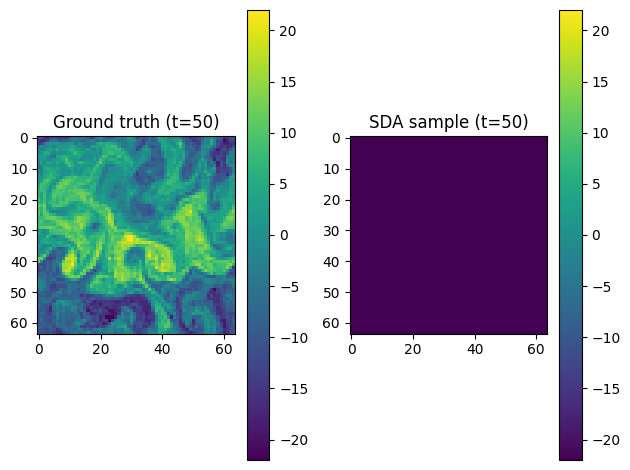

In [27]:
t = 50
ens = 0
# x_star_ = x_star.unflatten(0, (-1, 2)).cpu()
fig, axs = plt.subplots(1, 2)
im0 = axs[0].imshow(scalefact*pv_truth[t,0].cpu().numpy(), vmax=22, vmin=-22)
axs[0].set_title(f"Ground truth (t={t})")
im1 = axs[1].imshow(posterior_sample[0,t,0], vmax=22, vmin=-22)
axs[1].set_title(f"SDA sample (t={t})")
plt.colorbar(im0)
plt.colorbar(im1)
plt.tight_layout()

In [ ]:
guided_score = GaussianScore(
                    y,
                    A=A,
                    std=obs_sigma,
                    sde=ScaledVPSDE(score_scaled, shape=(), scale=scale),
                    gamma=1e-2,
                )

z = torch.randn(y.shape).to(device)
x = z * scale
x = x.reshape(-1, 101, 2, 64, 64)
steps = 100
time = torch.linspace(1, 0, steps + 1).to(device)
dt = 1 / steps

t = time[0]
r = guided_sde.mu(t - dt) / guided_sde.mu(t)
g = guided_score(x, t, None)
x = r * x + (guided_sde.sigma(t - dt) - r * guided_sde.sigma(t)) * g

In [ ]:
plt.imshow(x[0,0,0].detach().cpu().numpy())
plt.colorbar()

In [ ]:
x.shape

# For debugging purpose

In [ ]:
import math

steps = 64
eta = 1e-3
scale = scalefact*pv_std
# scale = 1
z = torch.randn((10, 64, 64)).to(device)
x = z * scale
time = torch.linspace(1, 0, steps + 1).to(device)
dt = 1 / steps
corrections = 1
tau = 0.5

alpha = lambda t: torch.cos(math.acos(math.sqrt(eta)) * t) ** 2
mu = lambda t: alpha(t)
sigma = lambda t: scale * (1 - alpha(t)**2 + eta**2).sqrt()
eps = lambda x, t: score.kernel(x/scale, t)

with torch.no_grad():
    for t in tqdm(time[:-1], ncols=88):
        # Predictor
        r = mu(t - dt) / mu(t)
        x = r * x + (sigma(t - dt) - r * sigma(t)) * eps(x, t)

        # Corrector
        for _ in range(corrections):
            z = torch.randn_like(x)
            eps_ = eps(x, t - dt)
            delta = tau / eps_.square().mean(dim=(-2, -1), keepdim=True)

            x = x - (delta * eps_ + torch.sqrt(2 * delta) * z) * sigma(t - dt)

In [ ]:
x = x.unflatten(0, (-1, 2))
plt.imshow(x[0,0].cpu().numpy())
plt.colorbar()

In [ ]:
plt.imshow(scalefact*pv_truth[0,0].cpu().numpy(), vmin=-22, vmax=25)
plt.colorbar()

In [ ]:
scale = scalefact*pv_std
z = torch.randn((10, 64, 64)).to(device)
x = z * scale
t = torch.tensor(0, device=device)
mu_, sigma_ = mu(t), sigma(t)
eps_ = eps(x / scale, t)

x_ = (x - scale * sigma_ * eps_) / mu_
x_ = x_.unflatten(0, (-1, 2))

In [ ]:
plt.imshow(x_[0,0].detach().cpu().numpy())
plt.colorbar()

In [ ]:
plt.imshow((y[0] - A_scaled(x_[0]))[0].detach().cpu().numpy())
plt.colorbar()

In [ ]:
scale = scalefact*pv_std
eta = 1e-3
alpha = lambda t: torch.cos(math.acos(math.sqrt(eta)) * t) ** 2
mu = lambda t: alpha(t)
sigma = lambda t: scale * (1 - alpha(t)**2 + eta**2).sqrt()
eps = lambda x, t: score.kernel(x / scale, t)

z = torch.randn((10, 64, 64)).to(device)
x = z * scale

def get_grad(x_, t):
    with torch.enable_grad():
        x_ = x_.detach().requires_grad_(True)
        mu_, sigma_ = mu(t), sigma(t)
        eps_ = eps(x_, t)
        x_hat = (x_ - sigma_ * eps_) / mu_
        x_hat = x_hat.unflatten(0, (-1, 2))
        err = y[0] - A(x_hat[0])
        var = obs_sigma ** 2 + 1e-2 * (sigma_ / mu_) ** 2
        log_p = -(err ** 2 / var).sum() / 2
    
    s, = torch.autograd.grad(log_p, x_)
    grad = eps_ - (sigma_) * s
    return grad

def sample(steps, corrections, tau):
    z = torch.randn((10, 64, 64)).to(device)
    x = z * scale
    
    time = torch.linspace(1, 0, steps + 1).to(device)
    dt = 1 / steps

    with torch.no_grad():
        # import ipdb; ipdb.set_trace()
        grads = []
        for t in tqdm(time[:-1], ncols=88):
            # Predictor
            r = mu(t - dt) / mu(t)
            grad = get_grad(x, t)
            x = r * x + (sigma(t - dt) - r * sigma(t)) * grad
            grads.append(grad)
    
            # Corrector
            for _ in range(corrections):
                z = torch.randn_like(x)
                eps = get_grad(x, t - dt)
                delta = tau / eps.square().mean(dim=(-1,-2), keepdim=True)
    
                x = x - (delta * eps + torch.sqrt(2 * delta) * z) * sigma(t - dt)

    return x.unflatten(0, (-1, 2)), grads


In [ ]:
z = torch.randn((10, 64, 64)).to(device)
x = z * scale
time = torch.linspace(1, 0, steps + 1).to(device)
t = time[0]
r = mu(t - dt) / mu(t)
grad = get_grad(x, t)
print(grad.max())
plt.imshow(grad[0].detach().cpu().numpy())
plt.colorbar()

In [ ]:
z = torch.randn((10, 64, 64)).to(device)
x = z * scale
x = r * x + (sigma(t - dt) - r * sigma(t)) * grad
x = x.unflatten(0, (-1, 2))
plt.imshow(x[0,0].detach().cpu().numpy())
plt.colorbar()

In [ ]:
x, grads = sample(64, 1, 0.5)

In [ ]:
fig, axs = plt.subplots(1, 2)
im0 = axs[0].imshow(scalefact*pv_truth[0,0].cpu().numpy())
axs[0].set_title(f"Ground truth (t={t})")
im1 = axs[1].imshow(x[-1,0].detach().cpu().numpy())
axs[1].set_title(f"SDA sample (t={t})")
plt.colorbar(im0)
plt.colorbar(im1)
plt.tight_layout()